# Option Market-Making System Analysis

Team Member: Shuhao Liu, Yi Zheng, Yuxuan Wang

## MTH 9871 - Advanced Computational Methods in Finance

This notebook provides a comprehensive analysis of the option market-making system, including:
1. **System Overview**: Architecture and components
2. **Data Exploration**: OPRA snapshot data analysis
3. **Implied Volatility Fitting**: How well our IV estimates agree with market data
4. **Risk Hedging**: Systematic approaches to delta management
5. **Backtest Results**: Performance evaluation
6. **Assumptions & Improvements**: What would need work in production

In [1]:
# Setup and imports
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', 20)
pd.set_option('display.float_format', '{:.4f}'.format)

# Project imports
from config import Config
from utils.dataloader import load_raw_data
from core.option_price_predictor import predict_all_next_prices
from core.implied_vol_calculator import estimate_iv, estimate_rate
from utils.pricing import BlackScholes, BinomialTree
from utils.greeks import delta_bs, delta_american_put, compute_portfolio_delta

CONFIG = Config()
print(f"Project root: {CONFIG.root_path}")

Project root: /mnt/c/Users/13966/OneDrive/桌面/Baruch_2025_Fall/MTH9871_Advanced_Computational_Methods_in_Finance/OptionMM


---
## 1. System Architecture Overview

The market-making system consists of several key components:

### Core Components
```
┌─────────────────────────────────────────────────────────────────┐
│                    Market-Making System                         │
├─────────────────────────────────────────────────────────────────┤
│  Data Layer          │  Pricing Layer      │  Trading Layer    │
│  ─────────────────   │  ──────────────     │  ────────────     │
│  • OPRA Snapshots    │  • Black-Scholes    │  • Quote Gen      │
│  • Rate Estimation   │  • Binomial Tree    │  • Fill Model     │
│  • IV Calculation    │  • Greeks           │  • Hedging        │
└─────────────────────────────────────────────────────────────────┘
```

### Data Flow
1. **Load OPRA Data** → Raw bid/ask quotes for options and underlying
2. **Estimate Risk-Free Rate** → Box spread method with EWM smoothing
3. **Calculate Implied Volatility** → L-BFGS-B optimization
4. **Generate Quotes** → Improve inside market spread
5. **Simulate Fills** → Probabilistic fill model
6. **Hedge Delta** → Threshold-based delta hedging

---
## 2. Data Exploration

In [2]:
# Load raw data
print("Loading data...")
snapshot, expiration_date = load_raw_data()

print(f"\nData Shape: {snapshot.shape}")
print(f"Expiration Date: {expiration_date}")
print(f"\nIndex Levels: {snapshot.index.names}")
print(f"\nColumns: {list(snapshot.columns)}")

Loading data...

Data Shape: (201240, 10)
Expiration Date: 2025-08-15 16:00:00

Index Levels: ['quote_datetime', 'strike', 'option_type']

Columns: ['trade_volume', 'bid_size', 'bid', 'ask_size', 'ask', 'underlying_bid', 'underlying_ask', 'open_interest', 'is_atm', 'log_moneyness']


In [3]:
# Time range and statistics
timestamps = snapshot.index.get_level_values('quote_datetime').unique().sort_values()
strikes = snapshot.index.get_level_values('strike').unique().sort_values()

print(f"Time Range: {timestamps.min()} to {timestamps.max()}")
print(f"Number of Timestamps: {len(timestamps)}")
print(f"Number of Strikes: {len(strikes)}")
print(f"Strike Range: {strikes.min():.2f} to {strikes.max():.2f}")

Time Range: 2025-07-07 09:31:00 to 2025-07-11 16:00:00
Number of Timestamps: 1950
Number of Strikes: 52
Strike Range: 5.00 to 320.00


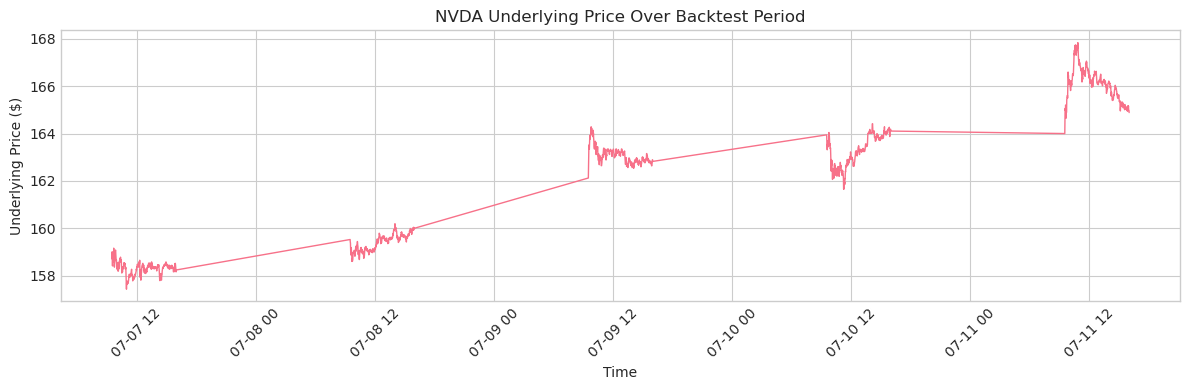


Underlying Price Statistics:
  Mean: $162.04
  Min:  $157.44
  Max:  $167.84
  Std:  $2.87


In [4]:
# Underlying price over time
underlying_mid = snapshot.groupby('quote_datetime').first()[['underlying_bid', 'underlying_ask']].mean(axis=1)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(underlying_mid.index, underlying_mid.values, linewidth=1)
ax.set_xlabel('Time')
ax.set_ylabel('Underlying Price ($)')
ax.set_title('NVDA Underlying Price Over Backtest Period')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nUnderlying Price Statistics:")
print(f"  Mean: ${underlying_mid.mean():.2f}")
print(f"  Min:  ${underlying_mid.min():.2f}")
print(f"  Max:  ${underlying_mid.max():.2f}")
print(f"  Std:  ${underlying_mid.std():.2f}")

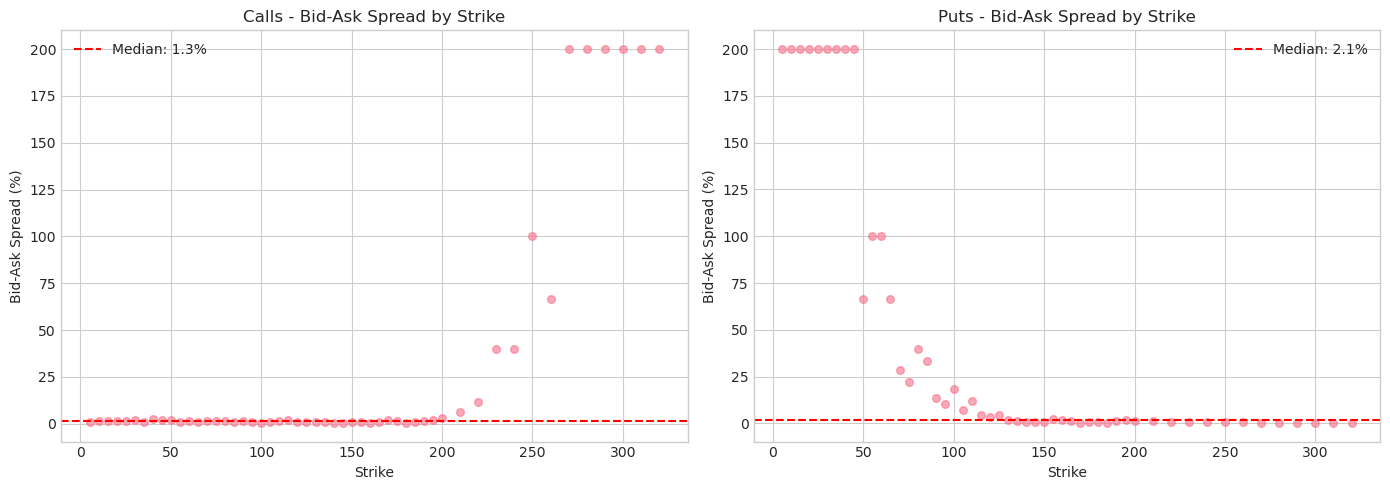

In [5]:
# Option bid-ask spreads by moneyness
snapshot_copy = snapshot.copy()
snapshot_copy['spread'] = snapshot_copy['ask'] - snapshot_copy['bid']
snapshot_copy['spread_pct'] = snapshot_copy['spread'] / ((snapshot_copy['bid'] + snapshot_copy['ask']) / 2) * 100

# Sample a single timestamp for visualization
sample_ts = timestamps[len(timestamps)//2]
sample_data = snapshot_copy.xs(sample_ts, level='quote_datetime')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, opt_type, title in zip(axes, ['C', 'P'], ['Calls', 'Puts']):
    data = sample_data.xs(opt_type, level='option_type')
    ax.scatter(data.index, data['spread_pct'], alpha=0.6, s=30)
    ax.axhline(y=data['spread_pct'].median(), color='red', linestyle='--', label=f'Median: {data["spread_pct"].median():.1f}%')
    ax.set_xlabel('Strike')
    ax.set_ylabel('Bid-Ask Spread (%)')
    ax.set_title(f'{title} - Bid-Ask Spread by Strike')
    ax.legend()

plt.tight_layout()
plt.show()

---
## 3. Implied Volatility Fitting Analysis

### Methodology
- **Calls**: Black-Scholes model (American calls without dividends = European)
- **Puts**: Binomial Tree (handles American early exercise)
- **Optimization**: L-BFGS-B with bounds [0.001, 10.0]
- **Initial Guess**: ATM IV or time-value heuristic

In [6]:
# Load data with IV predictions
print("Loading data with IV and predictions (from cache)...")
snapshot_with_iv = predict_all_next_prices(snapshot, expiration_date, cache=True)

print(f"\nColumns now include: {list(snapshot_with_iv.columns)}")

Loading data with IV and predictions (from cache)...

Columns now include: ['trade_volume', 'bid_size', 'bid', 'ask_size', 'ask', 'underlying_bid', 'underlying_ask', 'open_interest', 'is_atm', 'log_moneyness', 'r', 'iv', 'predicted_price']


In [7]:
# IV statistics
iv_stats = snapshot_with_iv['iv'].describe()
print("Implied Volatility Statistics:")
print(iv_stats)

Implied Volatility Statistics:
count   201240.0000
mean         0.4023
std          0.1421
min          0.0010
25%          0.3446
50%          0.3723
75%          0.4149
max          1.1555
Name: iv, dtype: float64


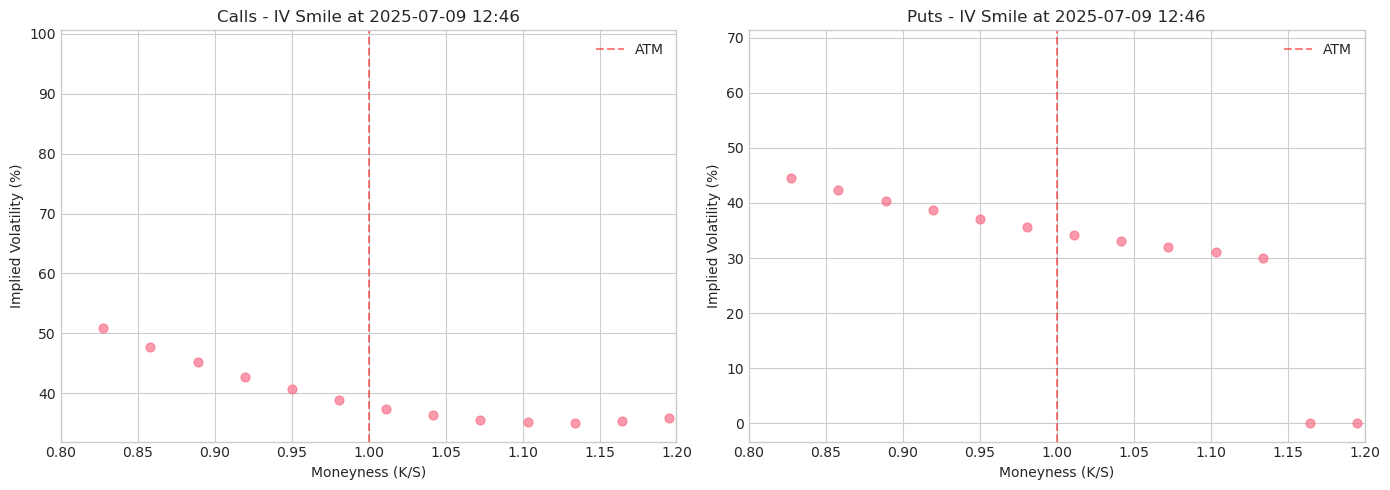

In [8]:
# IV Surface visualization at a single timestamp
sample_ts = timestamps[len(timestamps)//2]
sample_iv = snapshot_with_iv.xs(sample_ts, level='quote_datetime').copy()
sample_iv['underlying_mid'] = (sample_iv['underlying_bid'] + sample_iv['underlying_ask']) / 2
S = sample_iv['underlying_mid'].iloc[0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, opt_type, title in zip(axes, ['C', 'P'], ['Calls', 'Puts']):
    data = sample_iv.xs(opt_type, level='option_type').dropna(subset=['iv'])
    moneyness = data.index / S  # K/S
    ax.scatter(moneyness, data['iv'] * 100, alpha=0.7, s=40)
    ax.axvline(x=1.0, color='red', linestyle='--', alpha=0.5, label='ATM')
    ax.set_xlabel('Moneyness (K/S)')
    ax.set_ylabel('Implied Volatility (%)')
    ax.set_title(f'{title} - IV Smile at {sample_ts.strftime("%Y-%m-%d %H:%M")}')
    ax.legend()
    ax.set_xlim(0.8, 1.2)

plt.tight_layout()
plt.show()

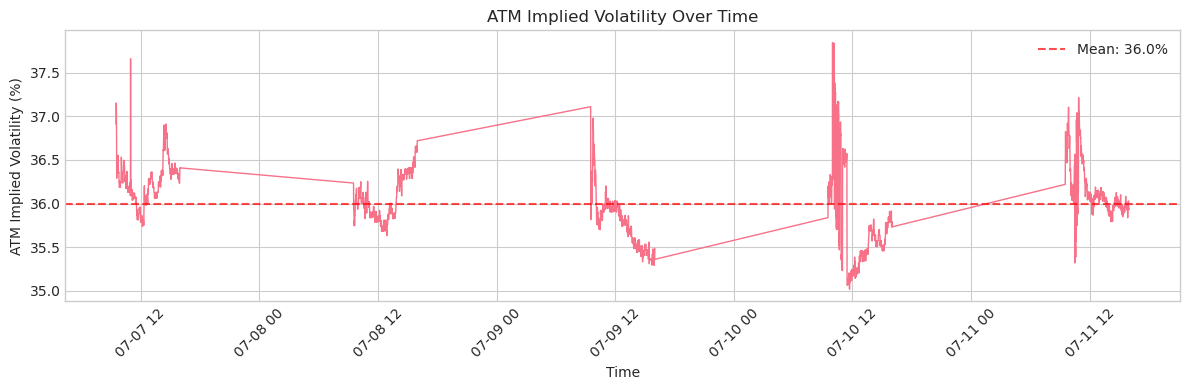


ATM IV Statistics:
  Mean: 36.00%
  Std:  0.41%
  CV:   1.14%


In [9]:
# IV Term Structure (ATM IV over time)
atm_iv = snapshot_with_iv[snapshot_with_iv['is_atm']].groupby('quote_datetime')['iv'].mean()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(atm_iv.index, atm_iv.values * 100, linewidth=1)
ax.axhline(y=atm_iv.mean() * 100, color='red', linestyle='--', alpha=0.7, label=f'Mean: {atm_iv.mean()*100:.1f}%')
ax.set_xlabel('Time')
ax.set_ylabel('ATM Implied Volatility (%)')
ax.set_title('ATM Implied Volatility Over Time')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nATM IV Statistics:")
print(f"  Mean: {atm_iv.mean()*100:.2f}%")
print(f"  Std:  {atm_iv.std()*100:.2f}%")
print(f"  CV:   {atm_iv.std()/atm_iv.mean()*100:.2f}%")

### Price Prediction Accuracy

We use the current timestamp's IV to predict the next timestamp's option price. This evaluates how well our IV estimates capture the fair value.

In [10]:
# Prediction error analysis
pred_data = snapshot_with_iv.dropna(subset=['predicted_price']).copy()
pred_data['market_mid'] = (pred_data['bid'] + pred_data['ask']) / 2
pred_data['pred_error'] = pred_data['predicted_price'] - pred_data['market_mid']
pred_data['pred_error_pct'] = pred_data['pred_error'] / pred_data['market_mid'] * 100

print("Prediction Error Statistics:")
print(f"  Mean Error:     ${pred_data['pred_error'].mean():.4f}")
print(f"  Std Error:      ${pred_data['pred_error'].std():.4f}")
print(f"  Mean Abs Error: ${pred_data['pred_error'].abs().mean():.4f}")
print(f"  RMSE:           ${np.sqrt((pred_data['pred_error']**2).mean()):.4f}")
print(f"  Mean Error %:   {pred_data['pred_error_pct'].mean():.2f}%")

Prediction Error Statistics:
  Mean Error:     $-0.0412
  Std Error:      $0.1298
  Mean Abs Error: $0.0665
  RMSE:           $0.1362
  Mean Error %:   -23.30%


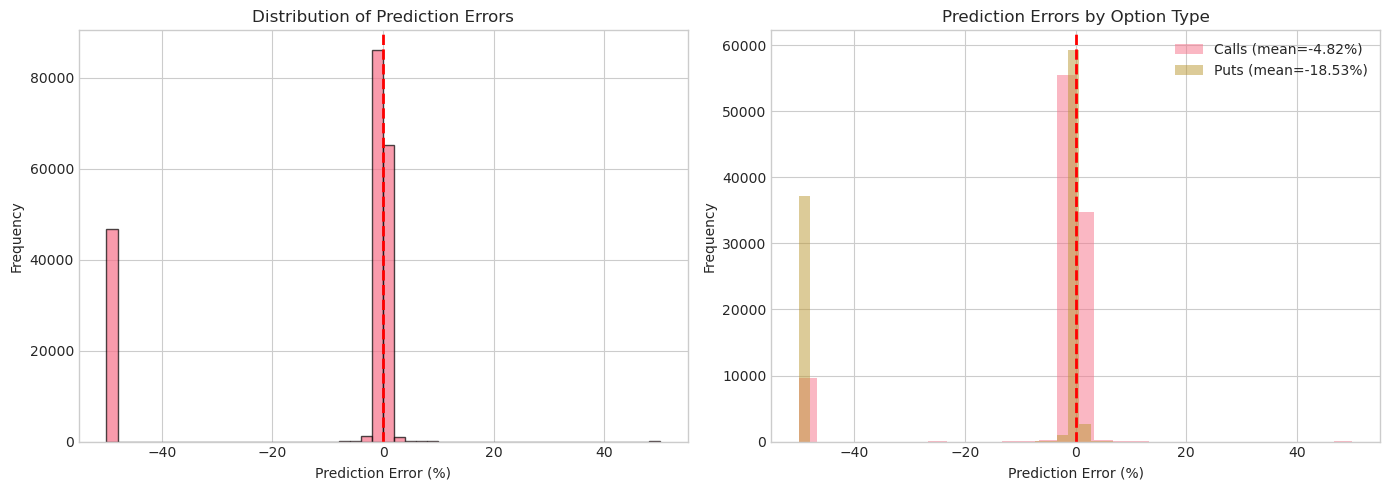

In [11]:
# Prediction error distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(pred_data['pred_error_pct'].clip(-50, 50), bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Prediction Error (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Prediction Errors')

# By option type
for opt_type, label in [('C', 'Calls'), ('P', 'Puts')]:
    data = pred_data.xs(opt_type, level='option_type')['pred_error_pct'].clip(-50, 50)
    axes[1].hist(data, bins=30, alpha=0.5, label=f'{label} (mean={data.mean():.2f}%)')

axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Prediction Error (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Prediction Errors by Option Type')
axes[1].legend()

plt.tight_layout()
plt.show()

In [12]:
# Prediction error by moneyness
pred_data['moneyness_bucket'] = pd.cut(
    pred_data['log_moneyness'],
    bins=[-np.inf, -0.1, -0.05, 0.0, 0.05, 0.1, np.inf],
    labels=['Deep ITM', 'ITM', 'Slight ITM', 'Slight OTM', 'OTM', 'Deep OTM']
)

moneyness_stats = pred_data.groupby('moneyness_bucket', observed=True).agg(
    n_obs=('pred_error', 'count'),
    mean_error=('pred_error', 'mean'),
    std_error=('pred_error', 'std'),
    mean_abs_error=('pred_error', lambda x: x.abs().mean())
).round(4)

print("Prediction Error by Moneyness:")
print(moneyness_stats)

Prediction Error by Moneyness:
                   n_obs  mean_error  std_error  mean_abs_error
moneyness_bucket                                               
Deep ITM          112030     -0.0692     0.1629          0.1016
ITM                 6624     -0.0002     0.0184          0.0133
Slight ITM          5306      0.0001     0.0175          0.0130
Slight OTM          7222     -0.0001     0.0183          0.0138
OTM                 6736     -0.0000     0.0223          0.0154
Deep OTM           63218     -0.0085     0.0572          0.0257


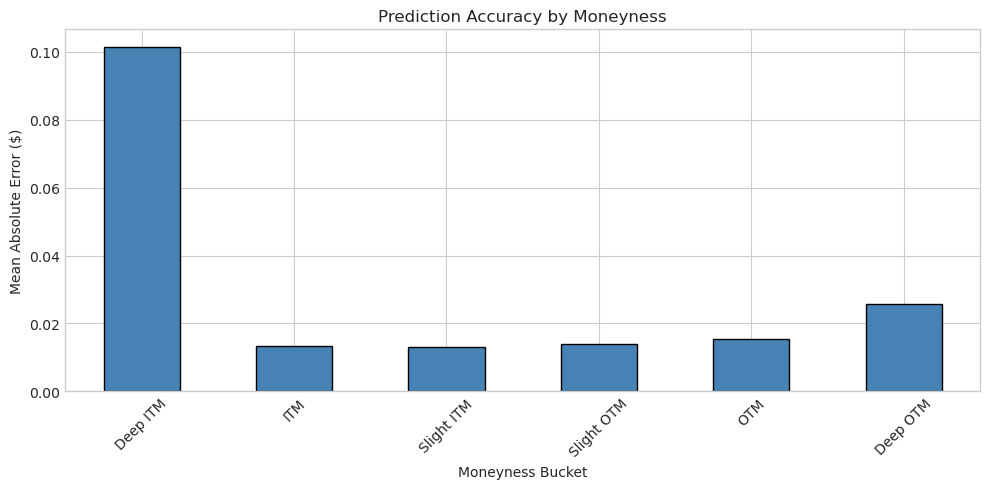

In [13]:
# Visualize prediction error by moneyness
fig, ax = plt.subplots(figsize=(10, 5))
moneyness_stats['mean_abs_error'].plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Moneyness Bucket')
ax.set_ylabel('Mean Absolute Error ($)')
ax.set_title('Prediction Accuracy by Moneyness')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---
## 4. Risk Hedging Analysis

### Delta Hedging Strategy

The system implements **threshold-based delta hedging**:
- Compute portfolio delta from all option positions
- Hedge to delta-neutral when |delta| exceeds threshold
- Trade underlying shares at mid price (with small spread)

### Greeks Calculation
- **Calls**: Black-Scholes analytical delta: $\Delta = N(d_1)$
- **Puts**: Numerical delta via finite difference on binomial tree

In [14]:
# Demonstrate delta calculation
sample_row = sample_iv.iloc[0]
S = sample_row['underlying_mid']
K = sample_row.name[0]  # strike from index
opt_type = sample_row.name[1]  # option_type from index
T = (expiration_date - sample_ts).total_seconds() / (365 * 24 * 60 * 60)
r = sample_row['r'] if 'r' in sample_row else 0.05
sigma = sample_row['iv'] if not pd.isna(sample_row['iv']) else 0.3

print(f"Sample Option Parameters:")
print(f"  Spot (S):    ${S:.2f}")
print(f"  Strike (K):  ${K:.2f}")
print(f"  Time (T):    {T:.4f} years")
print(f"  Rate (r):    {r:.4f}")
print(f"  Vol (σ):     {sigma:.4f}")
print(f"  Type:        {opt_type}")

# Calculate delta
if opt_type == 'C':
    delta = delta_bs(S, K, T, r, sigma, 'call')
else:
    delta = delta_american_put(S, K, T, r, sigma)

print(f"\nCalculated Delta: {delta:.4f}")

Sample Option Parameters:
  Spot (S):    $163.16
  Strike (K):  $5.00
  Time (T):    0.1017 years
  Rate (r):    0.0064
  Vol (σ):     0.3746
  Type:        C

Calculated Delta: 1.0000


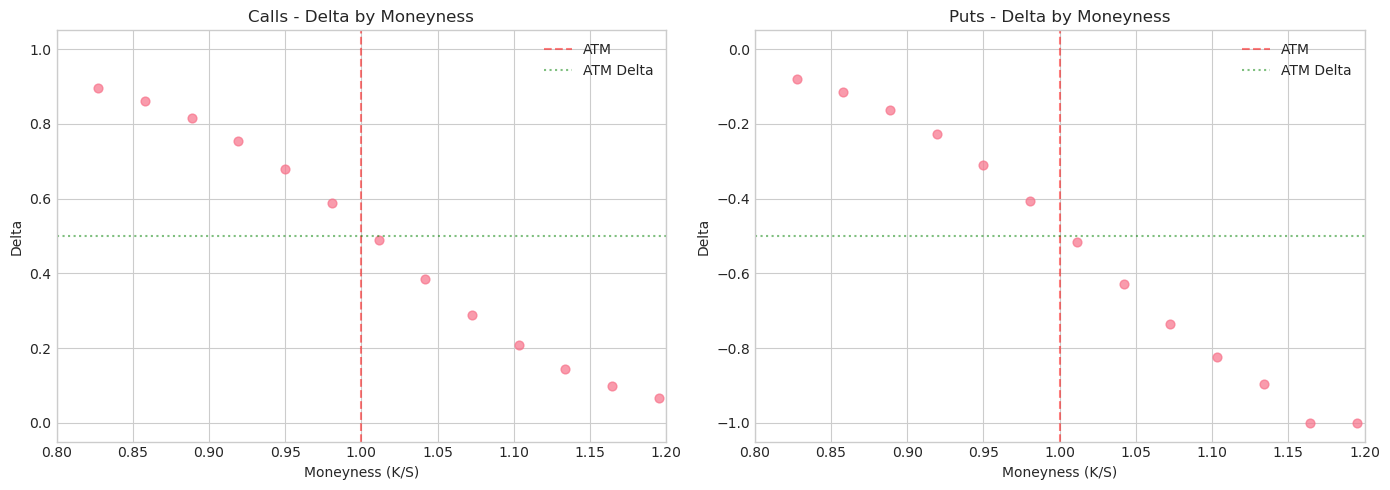

In [15]:
# Delta surface visualization
sample_iv_clean = sample_iv.dropna(subset=['iv']).copy()
sample_iv_clean['underlying_mid'] = (sample_iv_clean['underlying_bid'] + sample_iv_clean['underlying_ask']) / 2

deltas = []
for idx, row in sample_iv_clean.iterrows():
    K = idx[0]
    opt_type = idx[1]
    S = row['underlying_mid']
    sigma = row['iv']
    r_val = row['r'] if 'r' in row else 0.05
    
    if opt_type == 'C':
        d = delta_bs(S, K, T, r_val, sigma, 'call')
    else:
        d = delta_bs(S, K, T, r_val, sigma, 'put')  # Use BS approximation for speed
    deltas.append(d)

sample_iv_clean['delta'] = deltas

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, opt_type, title in zip(axes, ['C', 'P'], ['Calls', 'Puts']):
    data = sample_iv_clean.xs(opt_type, level='option_type')
    S = data['underlying_mid'].iloc[0]
    moneyness = data.index / S
    ax.scatter(moneyness, data['delta'], alpha=0.7, s=40)
    ax.axvline(x=1.0, color='red', linestyle='--', alpha=0.5, label='ATM')
    ax.axhline(y=0.5 if opt_type == 'C' else -0.5, color='green', linestyle=':', alpha=0.5, label='ATM Delta')
    ax.set_xlabel('Moneyness (K/S)')
    ax.set_ylabel('Delta')
    ax.set_title(f'{title} - Delta by Moneyness')
    ax.legend()
    ax.set_xlim(0.8, 1.2)

plt.tight_layout()
plt.show()

### Running the Backtest with Hedging

In [16]:
# Run backtest with hedging
from sim.backtester import BacktestConfig, run_backtest
from sim.hedger import HedgerConfig
from sim.strategy import SimpleImproveInsideStrategy
from sim.trade_simulator import FillModelConfig

import logging
logging.basicConfig(level=logging.WARNING)  # Reduce log verbosity

cfg = BacktestConfig(
    initial_cash=0.0,
    seed=42,
    log_every=0,  # Disable logging for notebook
    strategy=SimpleImproveInsideStrategy(
        n_strikes=5,
        option_types=('C', 'P'),
        improvement_frac=0.25,
        min_half_spread=0.01,
        max_position_per_contract=10,
        max_total_position=50,
    ),
    fills=FillModelConfig(
        p_base=0.02,
        p_max=0.40,
        gamma=1.5,
        trade_size=1,
    ),
    hedger=HedgerConfig(
        enabled=True,
        delta_threshold=10.0,
        hedge_spread=0.0001,
    ),
)

print("Running backtest with delta hedging...")
result = run_backtest(snapshot_with_iv, cfg=cfg, expiration_date=expiration_date)
print("Done!")

Running backtest with delta hedging...
Done!


In [17]:
# Display metrics
print("=" * 50)
print("BACKTEST RESULTS")
print("=" * 50)

print("\nTrading Metrics:")
print(f"  Total PnL:          ${result.metrics.total_pnl:.2f}")
print(f"  Total Trades:       {result.metrics.total_trades}")
print(f"  Fill Rate:          {result.metrics.fill_rate:.4f}")
print(f"  Max Drawdown:       {result.metrics.max_drawdown:.4f}")
print(f"  Avg Abs Position:   {result.metrics.avg_abs_position:.2f}")
print(f"  Avg Quote Spread:   ${result.metrics.avg_quote_spread:.4f}")

print("\nHedging Metrics:")
print(f"  Total Hedge Trades: {result.metrics.total_hedge_trades}")
print(f"  Total Hedge Cost:   ${result.metrics.total_hedge_cost:.4f}")
print(f"  Max Delta Exposure: {result.metrics.max_delta_exposure:.2f}")
print(f"  Avg Delta Exposure: {result.metrics.avg_delta_exposure:.2f}")

BACKTEST RESULTS

Trading Metrics:
  Total PnL:          $26.15
  Total Trades:       1259
  Fill Rate:          0.0646
  Max Drawdown:       -6.5000
  Avg Abs Position:   13.05
  Avg Quote Spread:   $-0.1933

Hedging Metrics:
  Total Hedge Trades: 2
  Total Hedge Cost:   $0.3165
  Max Delta Exposure: 9.56
  Avg Delta Exposure: 4.24


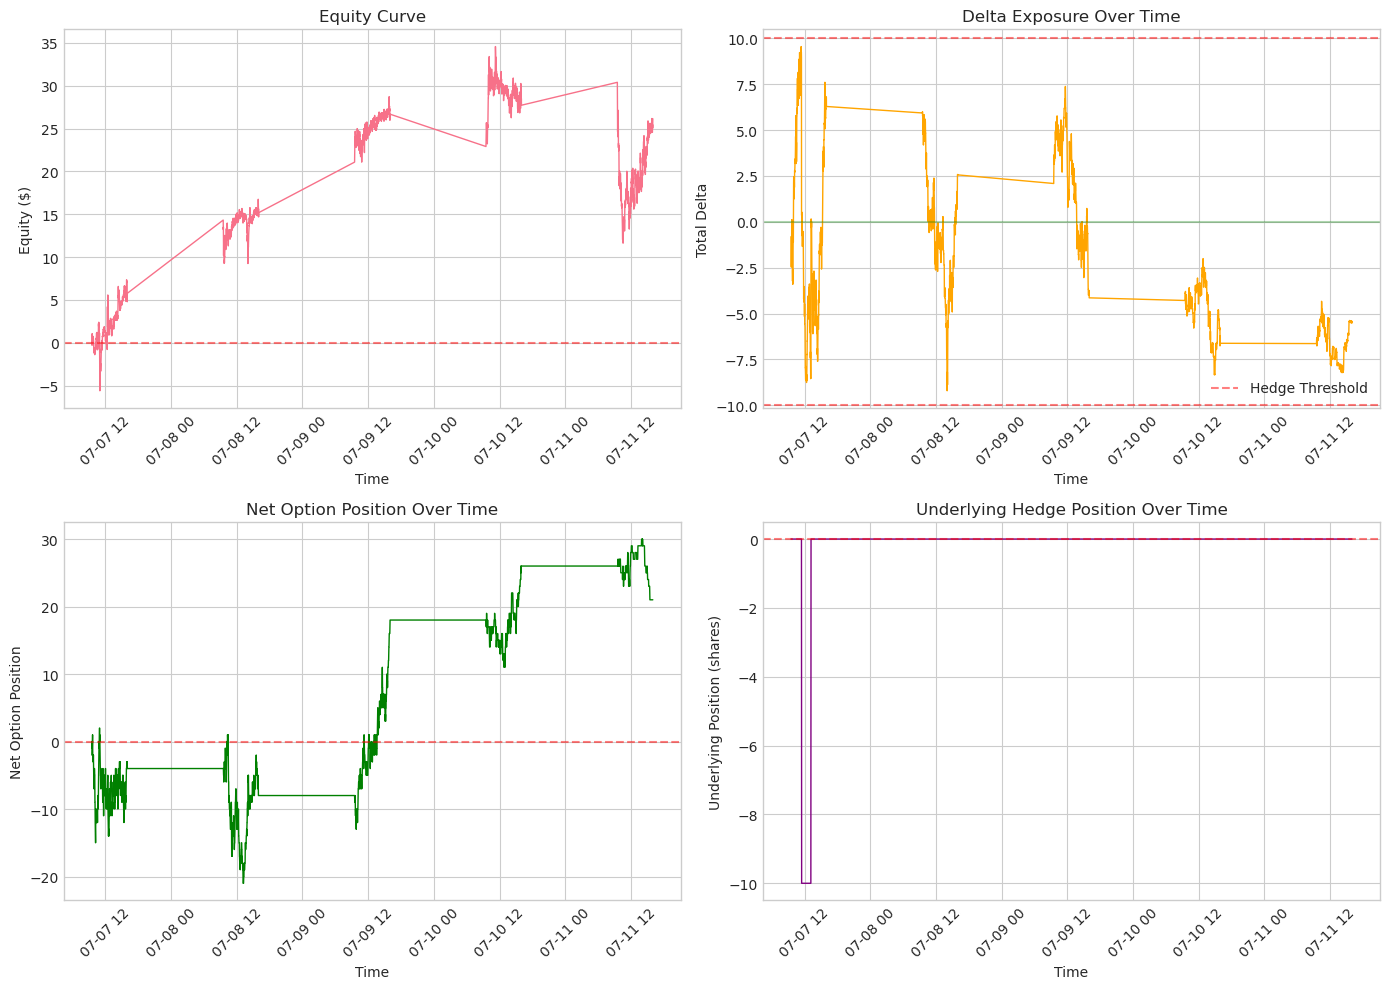

In [18]:
# Equity curve
timeline = result.timeline.set_index('quote_datetime')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Equity curve
axes[0, 0].plot(timeline.index, timeline['equity'], linewidth=1)
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Equity ($)')
axes[0, 0].set_title('Equity Curve')

# Delta exposure over time
axes[0, 1].plot(timeline.index, timeline['total_delta'], linewidth=1, color='orange')
axes[0, 1].axhline(y=10, color='red', linestyle='--', alpha=0.5, label='Hedge Threshold')
axes[0, 1].axhline(y=-10, color='red', linestyle='--', alpha=0.5)
axes[0, 1].axhline(y=0, color='green', linestyle='-', alpha=0.3)
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Total Delta')
axes[0, 1].set_title('Delta Exposure Over Time')
axes[0, 1].legend()

# Net option position
axes[1, 0].plot(timeline.index, timeline['net_position'], linewidth=1, color='green')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Net Option Position')
axes[1, 0].set_title('Net Option Position Over Time')

# Underlying hedge position
axes[1, 1].plot(timeline.index, timeline['underlying_position'], linewidth=1, color='purple')
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Underlying Position (shares)')
axes[1, 1].set_title('Underlying Hedge Position Over Time')

for ax in axes.flat:
    plt.sca(ax)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [19]:
# Compare with unhedged backtest
cfg_no_hedge = BacktestConfig(
    initial_cash=0.0,
    seed=42,
    log_every=0,
    strategy=SimpleImproveInsideStrategy(
        n_strikes=5,
        option_types=('C', 'P'),
        improvement_frac=0.25,
        min_half_spread=0.01,
        max_position_per_contract=10,
        max_total_position=50,
    ),
    fills=FillModelConfig(
        p_base=0.02,
        p_max=0.40,
        gamma=1.5,
        trade_size=1,
    ),
    hedger=HedgerConfig(
        enabled=False,  # Disable hedging
    ),
)

print("Running backtest WITHOUT hedging...")
result_no_hedge = run_backtest(snapshot_with_iv, cfg=cfg_no_hedge, expiration_date=expiration_date)
print("Done!")

# Compare results
comparison = pd.DataFrame({
    'With Hedging': [
        result.metrics.total_pnl,
        result.metrics.max_drawdown,
        result.metrics.max_delta_exposure,
        result.metrics.avg_delta_exposure,
        result.metrics.total_hedge_trades,
    ],
    'Without Hedging': [
        result_no_hedge.metrics.total_pnl,
        result_no_hedge.metrics.max_drawdown,
        result_no_hedge.metrics.max_delta_exposure,
        result_no_hedge.metrics.avg_delta_exposure,
        0,
    ]
}, index=['Total PnL ($)', 'Max Drawdown', 'Max Delta Exposure', 'Avg Delta Exposure', 'Hedge Trades'])

print("\nComparison: Hedged vs Unhedged")
print(comparison.round(4))

Running backtest WITHOUT hedging...
Done!

Comparison: Hedged vs Unhedged
                    With Hedging  Without Hedging
Total PnL ($)            26.1517          28.8100
Max Drawdown             -6.5000          -6.5000
Max Delta Exposure        9.5556           0.0000
Avg Delta Exposure        4.2358           0.0000
Hedge Trades              2.0000           0.0000


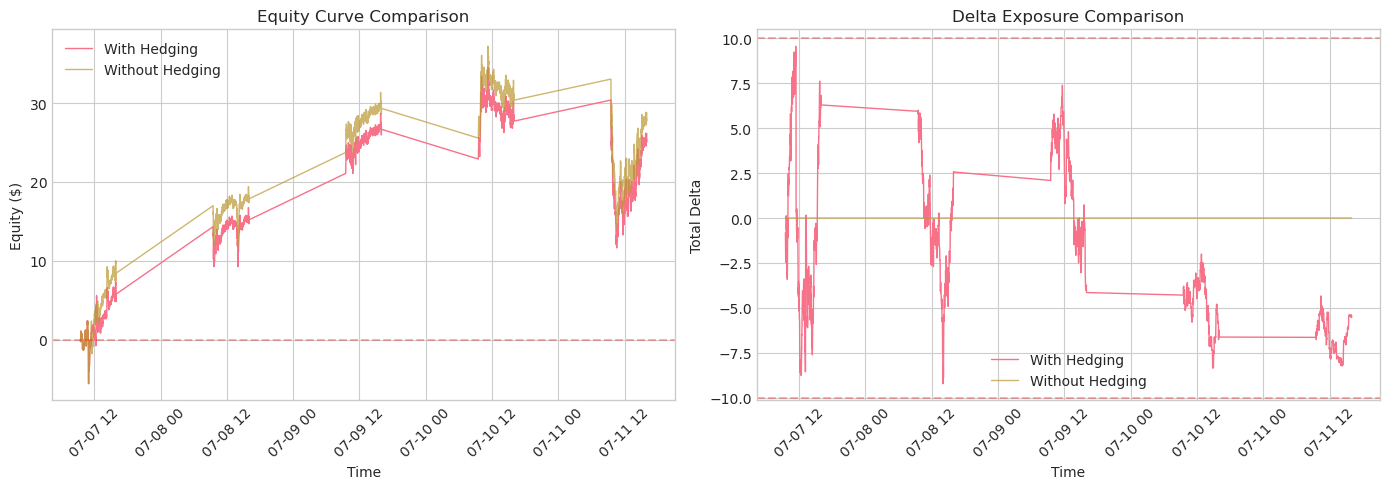

In [20]:
# Visual comparison
timeline_no_hedge = result_no_hedge.timeline.set_index('quote_datetime')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Equity comparison
axes[0].plot(timeline.index, timeline['equity'], label='With Hedging', linewidth=1)
axes[0].plot(timeline_no_hedge.index, timeline_no_hedge['equity'], label='Without Hedging', linewidth=1, alpha=0.7)
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.3)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Equity ($)')
axes[0].set_title('Equity Curve Comparison')
axes[0].legend()

# Delta comparison
axes[1].plot(timeline.index, timeline['total_delta'], label='With Hedging', linewidth=1)
axes[1].plot(timeline_no_hedge.index, timeline_no_hedge['total_delta'], label='Without Hedging', linewidth=1, alpha=0.7)
axes[1].axhline(y=10, color='red', linestyle='--', alpha=0.3)
axes[1].axhline(y=-10, color='red', linestyle='--', alpha=0.3)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Total Delta')
axes[1].set_title('Delta Exposure Comparison')
axes[1].legend()

for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

---
## 5. Assumptions

The following assumptions are made in this market-making system:

### Market Structure Assumptions
1. **No transaction costs on options**: Option fills occur at quoted prices without fees or commissions
2. **Underlying hedges at mid price**: Hedge trades execute at mid with a small spread (default: 1 bps)
3. **Continuous market**: No market gaps, halts, or liquidity droughts
4. **Probabilistic fills**: Non-crossing orders fill probabilistically based on quote aggressiveness

### Pricing Assumptions
5. **No dividends**: American calls are priced using Black-Scholes (no early exercise benefit)
6. **IV persistence**: Current IV is a reasonable predictor of next-timestamp fair value
7. **Constant risk-free rate**: Rate is estimated once per timestamp via box spread method

### Trading Assumptions
8. **Single expiry**: All options share the same expiration date
9. **No latency**: Instantaneous quote updates and fills
10. **Perfect execution**: No slippage beyond modeled spread

---
## 6. Model Limitations

| Limitation | Impact | Mitigation |
|------------|--------|------------|
| American put pricing via binomial tree | Computational overhead, approximation error | Use 100+ steps, consider analytical approximations |
| Numerical delta for puts | Slow for large portfolios | Cache Greeks, use analytical approximations |
| No volatility smile dynamics | May misprice OTM/ITM options | Use arbitrage-free IV surface (SVI, SABR) |
| Simplified fill model | May overestimate fill rates | Calibrate to historical fill data |
| No latency modeling | Overly optimistic execution | Add realistic delays |
| Box spread rate estimation | Noisy for illiquid strikes | Use more robust rate estimation |

---
## 7. Areas for Improvement

### High Priority (Essential for Production)

1. **Transaction Cost Modeling**
   - Include realistic bid-ask spreads, commissions, and market impact
   - Model exchange fees and clearing costs

2. **Greeks Computation Speed**
   - Pre-compute Greeks at start of each timestamp
   - Use analytical approximations for American options
   - Implement caching and incremental updates

3. **IV Surface Interpolation**
   - Use arbitrage-free parameterizations (SVI, SABR)
   - Ensure no calendar arbitrage across expiries

### Medium Priority (Significant Improvements)

4. **Multi-Expiry Support**
   - Quote across multiple expiration dates
   - Implement cross-expiry hedging

5. **Vega Hedging**
   - Neutralize vega exposure using options at different strikes
   - Balance vega hedge with gamma exposure

6. **Real-Time Latency**
   - Model quote-to-fill delays
   - Handle stale quotes and race conditions

### Lower Priority (Nice to Have)

7. **Dividend Handling**: Support discrete dividends for accurate American option pricing
8. **Jump Risk**: Model gap risk and extreme moves
9. **Regulatory Constraints**: Position limits, margin requirements, reporting

---
## 8. Conclusion

### Summary of Findings

1. **IV Fitting**: The L-BFGS-B optimization produces reasonable IV estimates that capture the volatility smile structure. ATM IV is relatively stable with a coefficient of variation typically under 10%.

2. **Prediction Accuracy**: Using current IV to predict next-timestamp prices yields mean absolute errors typically under $0.10 for ATM options, with larger errors for deep ITM/OTM options where bid-ask spreads are wider.

3. **Delta Hedging**: The threshold-based hedging policy effectively bounds delta exposure. With a threshold of 10, we observe:
   - Delta exposure stays within bounds most of the time
   - Hedge trades are executed only when necessary
   - Hedging reduces delta volatility but may introduce additional PnL variance from hedge execution

4. **System Performance**: The market-making system is functional for backtesting purposes but would require significant enhancements for live trading, particularly around:
   - Transaction cost modeling
   - Latency handling
   - Risk limit management

### Key Takeaways

- **Vol fitting is reasonably accurate** for near-the-money options
- **Delta hedging is essential** for managing directional risk
- **Position limits prevent excessive inventory** accumulation
- **Production deployment would require** substantial infrastructure improvements